## Library Import

In [2]:
# データの取り扱いに関するライブラリ
import numpy as np # 高速計算
import pandas as pd # 表データの扱い

# 可視化に関するライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import lightgbm as lgb

import gc

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 自身がファイルを格納したディレクトリを指定
ROOT_DIR = '../input/'
train_file_path = ROOT_DIR + 'train.csv'
test_file_path = ROOT_DIR + 'test.csv'
data_definition_path = ROOT_DIR + 'data_definition.xlsx'
submit_file_path = ROOT_DIR + 'sample_submit.csv'
output_path = '../output/'

## File Import

In [4]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [5]:
data_definition = pd.ExcelFile(data_definition_path)
data_definition_df = pd.read_excel(data_definition_path, sheet_name=data_definition.sheet_names[0])

In [6]:
pk_cols = ['building_id', 'unit_id']
date_col = 'target_ym'
target_col = 'money_room'
fe_cols = list(data_definition_df[data_definition_df['fe_cols'] == 1]['本番データ特徴量名'])

In [7]:
train_df[fe_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363924 entries, 0 to 363923
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   building_type          363924 non-null  int64  
 1   unit_count             227921 non-null  float64
 2   lon                    363924 non-null  float64
 3   lat                    363924 non-null  float64
 4   building_structure     348475 non-null  float64
 5   total_floor_area       113500 non-null  float64
 6   building_area          7026 non-null    float64
 7   floor_count            362627 non-null  float64
 8   year_built             349238 non-null  float64
 9   building_land_area     176487 non-null  float64
 10  land_area_all          63769 non-null   float64
 11  unit_area_min          126462 non-null  float64
 12  unit_area_max          126462 non-null  float64
 13  reform_exterior        16683 non-null   object 
 14  building_tag_id        335779 non-nu

## 前処理

### データの加工

#### 都道府県・市区町村情報の置換

In [8]:
codes = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[3])
codes.columns = ['No.', 'addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']
codes = codes[['addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']]

train_df = pd.merge(train_df, codes, on=['addr1_1', 'addr1_2'], how='inner')
test_df = pd.merge(test_df, codes, on=['addr1_1', 'addr1_2'], how='inner')

In [9]:
train_df.drop(['addr1_1', 'addr1_2'], axis=1, inplace=True)
test_df.drop(['addr1_1', 'addr1_2'], axis=1, inplace=True)
del codes

#### 欠損値・異常値の対応

In [10]:
n_train = len(train_df)

# ===== 1. 結合 =====
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# ===== 2. クリーニング（clean列を作る） =====
df['madori_number_clean'] = df['madori_number_all'].where(
    df['madori_number_all'].between(1, 7)
)

df['house_area_clean'] = df['house_area'].where(
    df['house_area'].between(10, 300)
)

df['snapshot_land_area_clean'] = df['snapshot_land_area'].where(
    df['snapshot_land_area'].between(10, 500)
)

valid_codes = [10, 20, 25, 30, 35, 40, 45, 50, 55]
df['madori_kind_clean'] = df['madori_kind_all'].where(
    df['madori_kind_all'].isin(valid_codes)
)

df['floor_count_clean'] = df['floor_count'].where(df['floor_count'] <= 62)

# building_type: 1→0, 3→1（その他はNaNにしてあとで補完）
df['building_type'] = df['building_type'].map({1: 0, 3: 1})

# ===== 3. building_id 単位で補完するためのヘルパー =====
def mode_or_nan(s: pd.Series):
    m = s.mode()
    return m.iloc[0] if not m.empty else np.nan

def median_or_nan(s: pd.Series):
    return s.median() if s.notna().any() else np.nan

g = df.groupby('building_id')

# --- mode 補完するカラム ---
mode_fill_specs = {
    'madori_number_all': 'madori_number_clean',
    'madori_kind_all':   'madori_kind_clean',
    'floor_count':       'floor_count_clean',
    'building_type':     'building_type',
}

for out_col, clean_col in mode_fill_specs.items():
    df[out_col] = g[clean_col].transform(mode_or_nan)

# --- median 補完するカラム ---
median_fill_specs = {
    'house_area':          'house_area_clean',
    'snapshot_land_area':  'snapshot_land_area_clean',
}

for out_col, clean_col in median_fill_specs.items():
    df[out_col] = g[clean_col].transform(median_or_nan)

# ===== 4. その他の補正・フラグ =====
# room_floor > floor_count の場合は floor_count でクリップ
mask = (df['room_floor'] > df['floor_count']) & df['floor_count'].notna()
df.loc[mask, 'room_floor'] = df.loc[mask, 'floor_count']

# 欠損フラグ
df['floor_count_missing']   = df['floor_count'].isna().astype(int)
df['building_type_missing'] = df['building_type'].isna().astype(int)

# ===== 5. 再び train / test に分割 =====
train_df = df.iloc[:n_train].copy()
test_df  = df.iloc[n_train:].copy()

#### log変換

In [11]:
log_cols = [
    'house_area',
    'snapshot_land_area',
    'building_land_area',
    'total_floor_area',
    'unit_count',
    'density_floor_area',
    'unit_count_density',
    'empty_ratio',
    'floor_area_ratio'
]

In [12]:
log_fe_cols = []

for df in [train_df, test_df]:
    for col in log_cols:
        if col in df.columns:
            new_col = f'{col}_log'
            # 負値はないはずだが、念のため0でクリップ
            df[new_col] = np.log1p(df[col].clip(lower=0))
            log_fe_cols.append(new_col)
log_fe_cols = sorted(set(log_fe_cols))

for df in [train_df, test_df]:
    df['tiny_area_flag_30'] = (df['house_area'] < 30).astype(int)   # 〜30㎡
    df['tiny_area_flag_40'] = (df['house_area'] < 40).astype(int)   # 〜40㎡

log_fe_cols += ['tiny_area_flag_30', 'tiny_area_flag_40']

### カテゴリ型の変換

#### 物件の種類

In [13]:
train_df['bukken_type'] = train_df['bukken_type'].map({1202: 0, 1302: 1})
test_df['bukken_type'] = test_df['bukken_type'].map({1202: 0, 1302: 1})

#### 都道府県・市区町村情報

In [14]:
adress_cols = ['Prefecture name', 'City/town/village name']

global_mean = train_df[target_col].mean()

for col in adress_cols:

    # Step1: train でカテゴリごとの平均を計算
    mapping = train_df.groupby(col)[target_col].mean()

    # Step2: train に map を適用
    train_df[col + '_te'] = train_df[col].map(mapping)

    # Step3: test にも map を適用（未知カテゴリは global_mean）
    test_df[col + '_te'] = test_df[col].map(mapping).fillna(global_mean)

#### reform関連

In [15]:
def get_slashed_tags(df, cols_list):
    """スラッシュ区切り列を 0/1 の int8 フラグ列に分解する"""
    temp_dfs = []
    for col in cols_list:

        temp_df = df[col].str.get_dummies(sep="/")
        # if is_tag_master:
        #     temp_df.rename(columns=tag_master, inplace=True)
        temp_df = temp_df.add_prefix(f"{col} ")
        temp_df = temp_df.astype('int8')

        temp_dfs.append(temp_df)

    # すべて結合
    temp_dfs = pd.concat(temp_dfs, axis=1).astype('int8')
    return temp_dfs

In [16]:
# --- train + test を結合 ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 新しいタグ列を生成 ---
slashed_cols = ["reform_interior", "reform_exterior", "reform_wet_area"]
slashed_df = get_slashed_tags(combined_df, slashed_cols)

In [17]:
reform_cols = slashed_df.columns.tolist()

# --- 元 DF に結合 ---
combined_df = pd.concat([combined_df, slashed_df], axis=1)

# --- スラッシュ区切り列を削除 ---
combined_df = combined_df.drop(columns=slashed_cols)

# --- 再分割 ---
train_df = combined_df.iloc[:len(train_df)].copy()
test_df  = combined_df.iloc[len(train_df):].copy()

In [18]:
del slashed_df
gc.collect()

70

### FE

#### 築年数

In [19]:
def parse_year(date_input):
    try:
        s = str(date_input)
        if len(s) < 4:
            return np.nan
        return int(s[:4])
    except:
        return np.nan

def add_age_features(df):
    # 元の year_built と target_ym の年だけ抽出
    df['built_year']  = df['year_built'].apply(parse_year)
    df['target_year'] = df['target_ym'].apply(parse_year)

    # 築年数 = 対象年 − 建築年
    df['built_diff'] = df['target_year'] - df['built_year']

    # 築年数がマイナスになることはありえないので NaN に修正
    df.loc[df['built_diff'] < 0, 'built_diff'] = np.nan

    return df

train_df = add_age_features(train_df)
test_df  = add_age_features(test_df)

#### 面積比

In [20]:
train_df['area_ratio'] = train_df['house_area'] / train_df['snapshot_land_area']
test_df['area_ratio'] = test_df['house_area'] / test_df['snapshot_land_area']

#### 相対階数

In [21]:
train_df['relative_floor'] = train_df['room_floor'] / train_df['floor_count']
test_df['relative_floor']  = test_df['room_floor'] / test_df['floor_count']

#### 密度

In [22]:
for df in [train_df, test_df]:
    # 1) 階数密度: 建物階数 / 建物面積
    df['floor_area_density'] = df['floor_count'] / df['house_area']
    df.loc[df['house_area'] <= 0, 'floor_area_density'] = np.nan

    # 2) 敷地あたり専有面積密度: 専有面積 / 区画面積
    df['unit_land_density'] = df['unit_area'] / df['snapshot_land_area']
    df.loc[df['snapshot_land_area'] <= 0, 'unit_land_density'] = np.nan

    # 3) 面積 / 部屋数: 1部屋あたり専有面積
    df['area_per_room'] = df['unit_area'] / df['madori_number_all']
    df.loc[df['madori_number_all'] <= 0, 'area_per_room'] = np.nan

#### 豪邸検出

In [23]:
for df in [train_df, test_df]:
    df['land_building_ratio'] = df['snapshot_land_area'] / df['house_area']
    df.loc[df['house_area'] <= 0, 'land_building_ratio'] = np.nan

#### 面積と築年の交互作用

In [24]:
for df in [train_df, test_df]:
    # 1) 建物面積 × 築年数（築浅・築古で傾きが変わるのを捉える）
    df['house_area_x_built_diff'] = df['house_area'] * df['built_diff']

    # 2) 専有面積 × 築年数
    df['unit_area_x_built_diff'] = df['unit_area'] * df['built_diff']

    # 3) 1部屋あたり面積 × 築年数
    #   → 同じ築年数でも「広くてゆとりのある間取り」のプレミアムを表現
    df['area_per_room_x_built_diff'] = df['area_per_room'] * df['built_diff']

#### building_idごとの統合特徴量

In [25]:
len_train = len(train_df)

# --- train + test を結合 ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 1) building_id ごとの median(house_area) ---
building_house_area_median = (
    combined_df.groupby("building_id")["house_area"]
               .median()
               .rename("building_house_area_median")
)

# --- 2) building_id ごとの max(room_floor) ---
building_room_floor_max = (
    combined_df.groupby("building_id")["room_floor"]
               .max()
               .rename("building_room_floor_max")
)

# --- 3) building_id ごとの unit_count（件数） ---
building_unit_count = (
    combined_df.groupby("building_id")["unit_id"]  # unit_id がなければ建物内 index をカウントでもOK
               .count()
               .rename("building_unit_count")
)

# --- まとめて結合 ---
combined_df = combined_df.join(building_house_area_median, on="building_id")
combined_df = combined_df.join(building_room_floor_max,   on="building_id")
combined_df = combined_df.join(building_unit_count,       on="building_id")

# --- 再び train / test に分割 ---
train_df = combined_df.iloc[:len_train].copy()  # 元の train 行数を使う
test_df  = combined_df.iloc[len_train:].copy()


#### 近傍価格特徴量

In [26]:
from sklearn.neighbors import BallTree

def add_neighbor_price_features(
    train_df,
    test_df,
    target_col='money_room',
    lat_col='lat',
    lon_col='lon',
    radius_km=1.0
):
    """
    train/test に「1km 以内の近傍価格特徴量」を追加する関数

    追加されるカラム:
      - mean_price_within_1km
      - median_price_within_1km
      - count_neighbors_1km
      - neighbor_price_std_1km
      - neighbor_price_iqr_1km
    """

    # --------------------
    # 0) 前処理 & 準備
    # --------------------
    train_df = train_df.copy()
    test_df  = test_df.copy()

    # 座標をラジアンに変換
    train_coords_rad = np.radians(train_df[[lat_col, lon_col]].values.astype(float))
    test_coords_rad  = np.radians(test_df[[lat_col, lon_col]].values.astype(float))

    # BallTree 構築（haversine 距離）
    tree = BallTree(train_coords_rad, metric='haversine')
    R_earth_km = 6371.0
    radius_rad = radius_km / R_earth_km

    y_train = train_df[target_col].to_numpy()
    n_train = len(train_df)
    n_test  = len(test_df)

    # --------------------
    # 1) train 側の近傍集計
    # --------------------
    mean_price_train   = np.full(n_train, np.nan, dtype=float)
    median_price_train = np.full(n_train, np.nan, dtype=float)
    count_neighbors_train = np.zeros(n_train, dtype=int)

    std_train = np.full(n_train, np.nan, dtype=float)
    iqr_train = np.full(n_train, np.nan, dtype=float)

    ind_array = tree.query_radius(
        train_coords_rad,
        r=radius_rad,
        return_distance=False,
        sort_results=False
    )

    for i, idx in enumerate(ind_array):
        idx = np.asarray(idx, dtype=int)

        # 自分自身を除外
        idx = idx[idx != i]

        # --- 平均・中央値・件数 ---
        if len(idx) > 0:
            prices = y_train[idx]
            mean_price_train[i]   = prices.mean()
            median_price_train[i] = np.median(prices)
            count_neighbors_train[i] = len(idx)

        # --- 分散・IQR ---
        if len(idx) > 1:
            neigh_prices = y_train[idx]
            std_train[i] = np.std(neigh_prices)
            q75, q25 = np.percentile(neigh_prices, [75, 25])
            iqr_train[i] = q75 - q25

    train_df['mean_price_within_1km']   = mean_price_train
    train_df['median_price_within_1km'] = median_price_train
    train_df['count_neighbors_1km']     = count_neighbors_train
    train_df['neighbor_price_std_1km']  = std_train
    train_df['neighbor_price_iqr_1km']  = iqr_train

    # --------------------
    # 2) test 側の近傍集計（近傍は train だけ）
    # --------------------
    mean_price_test   = np.full(n_test, np.nan, dtype=float)
    median_price_test = np.full(n_test, np.nan, dtype=float)
    count_neighbors_test = np.zeros(n_test, dtype=int)

    std_test = np.full(n_test, np.nan, dtype=float)
    iqr_test = np.full(n_test, np.nan, dtype=float)

    ind_array_test = tree.query_radius(
        test_coords_rad,
        r=radius_rad,
        return_distance=False,
        sort_results=False
    )

    for i, idx in enumerate(ind_array_test):
        idx = np.asarray(idx, dtype=int)

        if len(idx) > 0:
            prices = y_train[idx]
            mean_price_test[i]   = prices.mean()
            median_price_test[i] = np.median(prices)
            count_neighbors_test[i] = len(idx)

        if len(idx) > 1:
            neigh_prices = y_train[idx]
            std_test[i] = np.std(neigh_prices)
            q75, q25 = np.percentile(neigh_prices, [75, 25])
            iqr_test[i] = q75 - q25

    test_df['mean_price_within_1km']   = mean_price_test
    test_df['median_price_within_1km'] = median_price_test
    test_df['count_neighbors_1km']     = count_neighbors_test
    test_df['neighbor_price_std_1km']  = std_test
    test_df['neighbor_price_iqr_1km']  = iqr_test

    # --------------------
    # 3) 欠損埋め（近傍なしの物件）
    # --------------------
    global_mean_price   = np.nanmean(y_train)
    global_median_price = np.nanmedian(y_train)
    global_std  = np.nanmean(std_train)
    global_iqr  = np.nanmean(iqr_train)

    for df in [train_df, test_df]:
        df['mean_price_within_1km']   = df['mean_price_within_1km'].fillna(global_mean_price)
        df['median_price_within_1km'] = df['median_price_within_1km'].fillna(global_median_price)
        df['neighbor_price_std_1km']  = df['neighbor_price_std_1km'].fillna(global_std)
        df['neighbor_price_iqr_1km']  = df['neighbor_price_iqr_1km'].fillna(global_iqr)
        # count_neighbors_1km は 0 のままでOK

    return train_df, test_df


In [27]:
train_df, test_df = add_neighbor_price_features(
    train_df,
    test_df,
    target_col='money_room',
    lat_col='lat',
    lon_col='lon',
    radius_km=1.0
)

#### 緯度・経度を周期変換

In [28]:
# --- 緯度・経度をラジアンに ---
for df in [train_df, test_df]:
    df['lat_rad'] = np.radians(df['lat'].astype(float))
    df['lon_rad'] = np.radians(df['lon'].astype(float))

    # sin / cos 変換
    df['sin_lat'] = np.sin(df['lat_rad'])
    df['cos_lat'] = np.cos(df['lat_rad'])
    df['sin_lon'] = np.sin(df['lon_rad'])
    df['cos_lon'] = np.cos(df['lon_rad'])

#### 市区町村ごとの緯度・経度の中心

In [29]:
city_col = 'City/town/village name'

# --- ① train + test を結合 ---
combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# 既に city_lat/city_lon がある場合はいったん削除（任意）
for col in ['city_lat', 'city_lon']:
    if col in combined_df.columns:
        combined_df = combined_df.drop(columns=[col])

combined_df['lat'] = combined_df['lat'].astype(float)
combined_df['lon'] = combined_df['lon'].astype(float)

# --- ② 市区町村ごとの lat / lon の中央値 ---
city_lat_median = combined_df.groupby(city_col)['lat'].median()
city_lon_median = combined_df.groupby(city_col)['lon'].median()

# --- ③ 各レコードに city_lat / city_lon を付与 ---
combined_df['city_lat'] = combined_df[city_col].map(city_lat_median)
combined_df['city_lon'] = combined_df[city_col].map(city_lon_median)

# 型を float に統一
combined_df['city_lat'] = combined_df['city_lat'].astype('float')
combined_df['city_lon'] = combined_df['city_lon'].astype('float')

# --- ④ NaN を全体の中央値で埋める ---
combined_df['city_lat'] = combined_df['city_lat'].fillna(combined_df['lat'].median())
combined_df['city_lon'] = combined_df['city_lon'].fillna(combined_df['lon'].median())

# --- ⑤ 再分割 ---
train_df = combined_df.iloc[:len(train_df)].copy()
test_df  = combined_df.iloc[len(train_df):].copy()

#### タグ情報のOneHot

In [30]:
tag_info = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[2])
tag_info = tag_info[['タグID', 'タグ内容', 'タグ分類']]

facilities_info = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[4])
facilities_info = facilities_info[['タグID', 'タグ内容', 'タグ分類']]

In [31]:
tag_master = pd.concat([tag_info, facilities_info], axis=0, ignore_index=True).drop_duplicates()
tag_master['タグ情報'] = tag_master['タグ分類'] + '_' + tag_master['タグ内容']

In [32]:
tag_master["タグID"] = tag_master["タグID"].astype("str")
tag_master.set_index('タグID', inplace=True)
tag_master = tag_master.to_dict()['タグ情報']

In [33]:
combined_df = pd.concat([train_df, test_df], ignore_index=True)
org_tag_cols = ["building_tag_id", "unit_tag_id", "statuses"]

tag_dfs = []
for col in org_tag_cols:
    temp_df = combined_df[col].str.get_dummies(sep="/")
    temp_df.rename(columns=tag_master, inplace=True)
    temp_df = temp_df.astype('int8')

    tag_dfs.append(temp_df)

# すべて結合
tag_df = pd.concat(tag_dfs, axis=1).astype('int8')
tag_df = tag_df.groupby(level=0, axis=1).max()

In [34]:
tag_cols = tag_df.columns.drop_duplicates().tolist()

# --- 元 DF に結合 ---
combined_df = pd.concat([combined_df, tag_df], axis=1)

# --- スラッシュ区切り列を削除 ---
combined_df = combined_df.drop(columns=org_tag_cols)

# --- 再分割 ---
train_df = combined_df.iloc[:len(train_df)].copy()
test_df  = combined_df.iloc[len(train_df):].copy()

#### タグ情報のPCA

In [35]:
from sklearn.decomposition import PCA

# --- 1) combined_df を作成 ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# --- 2) タグ列グループ ---
tag_groups = {
    "building":  [c for c in combined_df.columns if "building_facilities_tag" in c],
    "unit":      [c for c in combined_df.columns if "unit_facilities_tag" in c],
    "condition": [c for c in combined_df.columns if "condition_tag" in c],
    "location":  [c for c in combined_df.columns if "location_tag" in c],
    "reform":    [c for c in combined_df.columns if "reform_or_cert_tag" in c]
}

# --- 2.5) グループごとの PCA 次元数 ---
pca_dims = {
    "building": 10,
    "unit": 5,
    "condition": 5,
    "location": 2,
    "reform": 5
}

# --- 3) PCA + 累積寄与率を計算する関数 ---
def add_pca_features_and_report(df, cols, prefix, n_components):
    if len(cols) == 0:
        print(f"[SKIP] {prefix}: No columns")
        return df

    # 列数より多い成分数は指定できないので調整しておく
    n_components = min(n_components, len(cols))

    X = df[cols].fillna(0)

    pca = PCA(n_components=n_components, random_state=42)
    pca_features = pca.fit_transform(X)

    # 新しい PCA 列を追加
    for i in range(n_components):
        df[f"{prefix}_pca_{i+1}"] = pca_features[:, i]

    # 累積寄与率を計算
    explained = pca.explained_variance_ratio_
    cum_explained = explained.cumsum()

    # 表示
    print(f"\n=== {prefix} PCA Explained Variance (n_components={n_components}) ===")
    for i, (e, c) in enumerate(zip(explained, cum_explained), start=1):
        print(f"PC{i}: {e:.4f},  Cumulative: {c:.4f}")
    print("========================================\n")

    return df


# --- 4) 各グループに対して PCA + 累積寄与率を表示 ---
for prefix, cols in tag_groups.items():
    n_comp = pca_dims.get(prefix, 0)
    if n_comp <= 0:
        print(f"[SKIP] {prefix}: n_components <= 0")
        continue

    combined_df = add_pca_features_and_report(
        combined_df,
        cols,
        prefix,
        n_components=n_comp
    )

# --- 5) train/test に戻す ---
train_len = len(train_df)
train_df = combined_df.iloc[:train_len].copy()
test_df  = combined_df.iloc[train_len:].copy()


=== building PCA Explained Variance (n_components=10) ===
PC1: 0.4176,  Cumulative: 0.4176
PC2: 0.1014,  Cumulative: 0.5189
PC3: 0.0646,  Cumulative: 0.5836
PC4: 0.0538,  Cumulative: 0.6374
PC5: 0.0460,  Cumulative: 0.6834
PC6: 0.0383,  Cumulative: 0.7217
PC7: 0.0358,  Cumulative: 0.7576
PC8: 0.0339,  Cumulative: 0.7915
PC9: 0.0302,  Cumulative: 0.8217
PC10: 0.0272,  Cumulative: 0.8489


=== unit PCA Explained Variance (n_components=5) ===
PC1: 0.2836,  Cumulative: 0.2836
PC2: 0.0709,  Cumulative: 0.3544
PC3: 0.0512,  Cumulative: 0.4056
PC4: 0.0343,  Cumulative: 0.4399
PC5: 0.0305,  Cumulative: 0.4705


=== condition PCA Explained Variance (n_components=5) ===
PC1: 0.2296,  Cumulative: 0.2296
PC2: 0.1876,  Cumulative: 0.4172
PC3: 0.1533,  Cumulative: 0.5705
PC4: 0.1132,  Cumulative: 0.6837
PC5: 0.0959,  Cumulative: 0.7795


=== location PCA Explained Variance (n_components=2) ===
PC1: 0.8595,  Cumulative: 0.8595
PC2: 0.0802,  Cumulative: 0.9397


=== reform PCA Explained Variance (n_c

#### タグのカウント

In [36]:
# --- train + test を結合 ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# --- building_tag / unit_tag / statuses の列名を抽出 ---
building_facilities_tag_cols = [c for c in combined_df.columns if "building_facilities_tag" in c]
unit_facilities_tag_cols = [c for c in combined_df.columns if "unit_facilities_tag" in c]
condition_tag_cols = [c for c in combined_df.columns if "condition_tag" in c]
location_tag_cols = [c for c in combined_df.columns if "location_tag" in c]
reform_or_cert_tag_cols = [c for c in combined_df.columns if "reform_or_cert_tag" in c]

combined_df["building_facilities_tag_count"] = combined_df[building_facilities_tag_cols].sum(axis=1)
combined_df["unit_facilities_tag_count"] = combined_df[unit_facilities_tag_cols].sum(axis=1)
combined_df["condition_tag_count"] = combined_df[condition_tag_cols].sum(axis=1)
combined_df["location_tag_count"] = combined_df[location_tag_cols].sum(axis=1)
combined_df["reform_or_cert_tag_count"] = combined_df[reform_or_cert_tag_cols].sum(axis=1)

# --- train / test に戻す ---
train_df = combined_df.iloc[:len(train_df)].copy()
test_df  = combined_df.iloc[len(train_df):].copy()

#### 交通情報

In [37]:
def add_access_zone_features(df, far_thresh=5000, error_thresh=20000, walk_speed=80):
    """
    交通系FEをまとめて付与する関数

    追加されるカラム:
      - walk_distance1_raw
      - access_zone           : 'walk', 'bus', 'car', 'error', 'unknown'
      - walk_distance1_error_flag
      - door_to_station_min   : 駅までの実質アクセス時間（徒歩 + バス）
      - door_to_station_min_log
    """
    df = df.copy()

    # 元の距離を退避
    df['walk_distance1_raw'] = df['walk_distance1']

    # 基本フラグ
    has_eki           = df['eki_name1'].notnull()
    has_bus_stop      = df['bus_stop1'].notnull()
    has_bus_time      = df['bus_time1'].notnull()
    has_traffic_other = df['traffic_other'].notnull()

    # =========================
    # 1) access_zone の分類
    # =========================
    df['access_zone'] = 'unknown'

    # 徒歩圏：駅あり & バス停なし
    mask_walk = has_eki & ~has_bus_stop
    df.loc[mask_walk, 'access_zone'] = 'walk'

    # バス圏：バス停あり（駅あり/なしどちらも）
    mask_bus = has_bus_stop
    df.loc[mask_bus, 'access_zone'] = 'bus'

    # 自動車圏候補：「駅までめっちゃ遠い」ケース
    very_far = df['walk_distance1_raw'] >= far_thresh

    # 1) traffic_other にコメントあり → 自動車圏
    mask_car1 = very_far & has_traffic_other

    # 2) 駅までの徒歩距離が far_thresh〜error_thresh 未満 → 自動車圏
    mask_car2 = very_far & (df['walk_distance1_raw'] < error_thresh)

    mask_car = mask_car1 | mask_car2

    # walk / bus / unknown のうち、car 条件を満たすものを上書き
    df.loc[mask_car, 'access_zone'] = 'car'

    # 20,000m 以上は入力ミス疑い
    mask_error = df['walk_distance1_raw'] >= error_thresh
    df.loc[mask_error, 'access_zone'] = 'error'

    # カテゴリ化
    df['access_zone'] = df['access_zone'].astype('category')

    # =========================
    # 2) 駅までの実質アクセス時間
    #    (door_to_station_min)
    # =========================
    # 自宅→徒歩時間（分）
    walk_min1 = df['walk_distance1_raw'] / walk_speed

    # 初期化
    df['door_to_station_min'] = np.nan

    # パターンA：駅あり + バス停あり + バス時間あり（徒歩＋バス）
    mask_A = has_eki & has_bus_stop & has_bus_time
    df.loc[mask_A, 'door_to_station_min'] = (
        walk_min1[mask_A] + df.loc[mask_A, 'bus_time1']
    )

    # パターンB：駅のみ → 徒歩のみ
    mask_B = has_eki & ~has_bus_stop
    df.loc[mask_B, 'door_to_station_min'] = walk_min1[mask_B]

    # パターンC（駅なし＋バスのみ）は NaN のまま
    # → bus_only_flag などで別途対処可能

    # 非線形吸収用ログ特徴量
    df['door_to_station_min_log'] = np.log1p(df['door_to_station_min'])

    return df

train_df = add_access_zone_features(train_df)
test_df  = add_access_zone_features(test_df)

In [38]:
for df in [train_df, test_df]:
    if 'walk_distance1_raw' not in df.columns:
        df['walk_distance1_raw'] = df['walk_distance1']

bins = [-1, 300, 700, 1500, 5000]
labels = ['0-300', '300-700', '700-1500', '1500-5000']

for df in [train_df, test_df]:
    df['walk_distance_bin'] = pd.cut(
        df['walk_distance1_raw'],
        bins=bins,
        labels=labels
    ).astype('category')

In [39]:
max_min = 60  # 上限は好みで 45 / 60 / 90 など試せる

for df in [train_df, test_df]:
    df['door_to_station_min_clip'] = df['door_to_station_min'].clip(0, max_min)
    df['door_to_station_min_clip_log'] = np.log1p(df['door_to_station_min_clip'])

In [40]:
traffic_te_cols = ['eki_name1', 'eki_name2', 'rosen_name1', 'rosen_name2']

global_mean = train_df[target_col].mean()

for col in traffic_te_cols:
    mapping = train_df.groupby(col)[target_col].mean()

    train_df[col + '_te'] = train_df[col].map(mapping)
    test_df[col + '_te']  = test_df[col].map(mapping).fillna(global_mean)

In [41]:
# 精度が上がらなかったため不採用だが、改善の余地はありそう（時間かけられなかった）
# train_df['walk_distance1_clean'] = train_df['walk_distance1_raw'].clip(0, error_thresh)
# train_df['walk_distance1_log']   = np.log1p(train_df['walk_distance1'])

# test_df['walk_distance1_clean'] = test_df['walk_distance1_raw'].clip(0, error_thresh)
# test_df['walk_distance1_log']   = np.log1p(test_df['walk_distance1'])

# fe_cols += ['walk_distance1_log']


# def add_bus_only_flag(df):
#     """
#     rosen_name1 に「バス」が含まれる → bus_only_flg = 1
#     それ以外は 0
#     """
#     df = df.copy()

#     # "バス" を含む路線名 → bus_only
#     is_bus_line = df['rosen_name1'].fillna('').str.contains('バス')

#     df['bus_only_flg'] = is_bus_line.astype(int)

#     return df

# train_df = add_bus_only_flag(train_df)
# test_df  = add_bus_only_flag(test_df)

# fe_cols += ['bus_only_flg']

#### 建物情報の拡充

In [42]:
def add_building_area_features(df):
    """
    建物規模系の追加特徴量を作成する
    - density_floor_area
    - unit_count_density
    - unit_area_range
    - empty_ratio
    - building_coverage_ratio（建ぺい率）
    - floor_area_ratio（容積率）
    """
    df = df.copy()

    # ================
    # 1) 延床面積密度
    # ================
    df['density_floor_area'] = df['total_floor_area'] / df['building_land_area']
    
    # ================
    # 2) 総戸数密度
    # ================
    df['unit_count_density'] = df['unit_count'] / df['building_land_area']

    # ================
    # 3) 専有面積の範囲（max-min）
    # ================
    df['unit_area_range'] = df['unit_area_max'] - df['unit_area_min']

    # ================
    # 4) 空室率
    #    unit_count = 0 のケースは NaN にする
    # ================
    df['empty_ratio'] = df['empty_number'] / df['unit_count']

    # ================
    # 5) 建ぺい率（建築面積 ÷ 敷地面積）
    # ================
    df['building_coverage_ratio'] = df['building_area'] / df['land_area_all']

    # ================
    # 6) 容積率（延べ床面積 ÷ 敷地面積）
    # ================
    df['floor_area_ratio'] = df['total_floor_area'] / df['land_area_all']

    return df

train_df = add_building_area_features(train_df)
test_df  = add_building_area_features(test_df)

#### リフォーム・リノベ情報の拡充

In [43]:
def add_effective_age(df, train_year, train_month):
    """
    ・実質築年数（effective_age）
    ・first_reform_yearmonth / first_reform_year
    ・effective_build_year
    ・reform_total_count（リフォーム箇所数）
    ・reform_newness（リフォームからの経過月数）
    ・reform_newness_log（log1p）
    を追加する
    """
    df = df.copy()

    # -------------------------
    # 1) リフォーム年月の最小値（最初のリフォーム）
    # -------------------------
    date_cols = ['reform_interior_date',
                 'reform_wet_area_date',
                 'renovation_date']

    # 数値化（YYYYMM想定）できないものは NaN
    reform_ym = df[date_cols].apply(
        pd.to_numeric, errors='coerce'
    )

    # 行ごとの最小YYYYMM（=一番古い or 最初に記録されたリフォーム年月）
    df['first_reform_yearmonth'] = reform_ym.min(axis=1)

    # 年に変換（YYYYMM → YYYY）
    df['first_reform_year'] = (df['first_reform_yearmonth'] // 100).astype('float')

    # -------------------------
    # 2) 実質築年（effective_build_year）＆ 実質築年数（effective_age）
    # -------------------------
    df['effective_build_year'] = np.where(
        df['first_reform_year'].notnull(),
        df['first_reform_year'],     # リフォームした年
        df['year_built']             # なければ元の築年
    )

    df['effective_age'] = train_year - df['effective_build_year']

    # -------------------------
    # 3) リフォーム箇所の合計数（reform_total_count）
    #    ※箇所OneHotだけを合計するようにフィルタ
    # -------------------------
    # reform_exterior*, reform_wet_area*, reform_interior* の 0/1 カラムを想定
    reform_flag_cols = df.filter(
        regex=r'^reform_(exterior|wet_area|interior)'
    ).columns

    if len(reform_flag_cols) > 0:
        # 数値化（"1", "0", None を 1/0 に強制変換）
        reform_flags = df[reform_flag_cols].apply(
            pd.to_numeric, errors='coerce'
        ).fillna(0).astype(int)

        df['reform_total_count'] = reform_flags.sum(axis=1)
    else:
        df['reform_total_count'] = 0

    # -------------------------
    # 4) リフォームの“新しさ”（経過月数）
    # -------------------------
    # 基準年月（YYYYMM）→ 通し月数に変換
    ref_total_months = train_year * 12 + train_month

    # first_reform_yearmonth がある場合のみ計算
    df['reform_newness'] = np.where(
        df['first_reform_yearmonth'].notnull(),
        ref_total_months - df['first_reform_yearmonth'],
        np.nan
    )

    df['reform_newness_log'] = np.log1p(df['reform_newness'])

    return df


In [44]:
# 例：target_ym の最大値から基準年・月を決める
train_max_ym = train_df['target_ym'].max()  # 例: 202210
train_year = train_max_ym // 100            # → 2022
train_month = train_max_ym % 100            # → 10

train_df = add_effective_age(train_df, train_year, train_month)
test_df  = add_effective_age(test_df, train_year, train_month)

In [45]:
for df in [train_df, test_df]:
    # effective_age が NaN になりうるので、0割防止のため +1
    df['area_age_ratio'] = df['house_area'] / (df['effective_age'] + 1.0)
    df['area_age_ratio_log'] = np.log1p(df['area_age_ratio'].clip(lower=0))

#### 近傍単価

In [46]:
eps = 1e-6

for df in [train_df, test_df]:
    df['unit_price_neighbor'] = df['mean_price_within_1km'] / (df['building_house_area_median'] + eps)
    df['unit_price_neighbor_log'] = np.log1p(df['unit_price_neighbor'].clip(lower=0))

## モデル学習

#### 使用特徴量の選択

In [47]:
fe_cols += [
    'Prefecture name', 'City/town/village name',
    'floor_count_missing', 'building_type_missing',
    'Prefecture name_te', 'City/town/village name_te',
    'built_diff', 'area_ratio', 'relative_floor',
    'floor_area_density', 'unit_land_density', 'area_per_room',
    'land_building_ratio',
    'house_area_x_built_diff', 'unit_area_x_built_diff',
    'building_house_area_median', 'building_room_floor_max', 'building_unit_count',
    'mean_price_within_1km', 'median_price_within_1km', 'count_neighbors_1km', 'neighbor_price_std_1km', 'neighbor_price_iqr_1km',
    'sin_lat', 'cos_lat', 'sin_lon', 'cos_lon',
    'city_lat', 'city_lon',
    'building_facilities_tag_count', 'unit_facilities_tag_count', 'condition_tag_count', 'location_tag_count', 'reform_or_cert_tag_count',
    'access_zone', 'walk_distance_bin', 'door_to_station_min_clip_log',
    'unit_area_range', 'building_coverage_ratio',
    'effective_age', 'reform_total_count', 'reform_newness_log', 'area_age_ratio_log',
    'unit_price_neighbor_log'
] + log_fe_cols + reform_cols + tag_cols + [c for c in train_df.columns if "pca" in c.lower()] + [c + '_te' for c in traffic_te_cols]

# 削除する特徴量
remove_cols = [
    'addr1_1', 'addr1_2',
    'building_tag_id', 'unit_tag_id', 'statuses',
    'lat', 'lon',
    'reform_date', 'reform_interior_date', 'reform_wet_area_date', 'renovation_date'
] + log_cols + slashed_cols
fe_cols = [c for c in fe_cols if c not in remove_cols]

In [48]:
cat_cols = adress_cols
cat_cols += list(reform_cols)
cat_cols += list(tag_cols)
obj_cols = train_df[fe_cols].select_dtypes(include='object').columns
cat_cols += list(obj_cols)

for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df[c]  = test_df[c].astype('category')

In [49]:
# すべての category 列のリスト
cat_cols = train_df.select_dtypes(['category']).columns.tolist()

# train/test 両方まとめて category → object → category にし直す
for col in cat_cols:
    # いったん object に戻す
    train_df[col] = train_df[col].astype(str)
    test_df[col]  = test_df[col].astype(str)

# もう一度 category として統一
for col in cat_cols:
    merged = pd.concat([train_df[col], test_df[col]], axis=0)
    merged = merged.astype('category')

    train_df[col] = merged.iloc[:len(train_df)].astype('category')
    test_df[col]  = merged.iloc[len(train_df):].astype('category')

#### モデルの学習

In [50]:
LOW_PRICE_TH = 10_000_000  # 低価格の閾値（1,000万円）

# =========================
# 1) 学習データの準備
# =========================
X_all = train_df[fe_cols]
y_all = train_df[target_col].astype(float)

# ※ log1p を使う場合は np.log1p / np.expm1 に変える
y_all_log = np.log(y_all)

# あなたの既存パラメータをここに入れる
base_params = {
    "n_estimators": 1000,
    "learning_rate": 0.05,
    "num_leaves": 100,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_jobs": -1
}

# =========================
# 2) ベースモデル（全体）
# =========================
base_model = lgb.LGBMRegressor(**base_params)
base_model.fit(X_all, y_all_log)

# =========================
# 3) 低価格帯だけのサブセットで学習
# =========================
mask_low = y_all <= LOW_PRICE_TH
X_low = X_all[mask_low]
y_low_log = y_all_log[mask_low]

low_params = base_params.copy()
# 低価格モデルは少しシンプルめにしてもよい（そのままでもOK）
low_params.update({
    "num_leaves": 64,
    "min_child_samples": 30,
})
low_model = lgb.LGBMRegressor(**low_params)
low_model.fit(X_low, y_low_log)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31931
[LightGBM] [Info] Number of data points in the train set: 363924, number of used features: 313
[LightGBM] [Info] Start training from score 16.872850
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, min_child_samples=30,
              n_estimators=1000, n_jobs=-1, num_leaves=64, random_state=42,
              subsample=0.8)

#### 学習データの精度確認

In [51]:
def predict_with_low_model(df, base_model, low_model,
                           fe_cols, low_price_th=LOW_PRICE_TH,
                           w_low=0.7):
    """
    ベースモデル + 低価格モデルのブレンド予測
    - base_model: 全体学習モデル
    - low_model : 低価格帯だけで学習したモデル
    - w_low     : 安い物件で low_model に寄せる比率（0〜1）
    """
    X = df[fe_cols]

    # log価格での予測
    base_log = base_model.predict(X)
    low_log  = low_model.predict(X)

    # ベースモデルの予測価格（元スケール）
    base_price = np.exp(base_log)  # log1p の場合は np.expm1

    # 低価格ゾーンのフラグ（ベース予測で判定）
    w = (base_price <= low_price_th).astype(float) * w_low

    # log空間でブレンド → 価格に戻す
    final_log = (1.0 - w) * base_log + w * low_log
    final_price = np.exp(final_log)  # log1p の場合は np.expm1

    return final_price

In [52]:
# train 上での予測
y_pred_train = predict_with_low_model(train_df, base_model, low_model, fe_cols)

y_true_train = train_df[target_col].astype(float)
mape_train = np.mean(
    np.abs(y_pred_train - y_true_train) / np.clip(y_true_train, 1e4, None)
)
print("MAPE Error:", mape_train)


MAPE Error: 0.08598759913163309


In [53]:
# MAPE Error  0.15901899972838118 # ハイブリッドPCA＋特徴量重要度2以下を削除（採用） v1(18.38982864307755)
# MAPE Error  0.158931750174125 # ハイブリッドPCA(分割数分ける)＋特徴量重要度2以下を削除（採用）
# MAPE Error  0.15799898879735255 # ハイブリッドPCA(分割数分ける、OneHot残す)＋特徴量重要度2以下を削除（採用） v2(18.29665009423758)
# MAPE Error  0.1431338075656053 # 特徴量をただ追加して、ObjectをCategoryにした
# MAPE Error  0.14313054260559416 # 経済圏のフラグ（採用）
# MAPE Error  0.14311366606471893 # ドアtoドア時間（採用）v3(18.636083203544363)
# MAPE Error  0.14311366606471893 # バスオンリーフラグ（不採用）　※改良の余地はありそう
# MAPE Error  0.14299165836212785 # 徒歩距離のビン化、徒歩距離のクリッピング、交通情報でのTE（採用）
# MAPE Error  0.14291317995128433 # 実質築年数（採用）
# MAPE Error  0.14278641647720797 # リフォームの新しさ、リフォーム箇所のカウント（採用）
# MAPE Error  0.14281362023852137　# 建物規模の特徴量を追加（MAPEは上がったが時間ないため採用）v4(18.684975247387374)
# MAPE Error  0.14269349527330982　# v4＋特徴量重要度2以下を削除 v5(18.676546472218753)

# MAPE Error  0.14301713169982383 # スクリプトの整形＋Log化＋特徴量重要度2以下を削除（採用）
# MAPE Error  0.14315478359998726 # 近傍単価の追加＋特徴量重要度2以下を削除（採用） v1(18.441987765969674)
# MAPE Error  0.14353968934147698 # 相場比率をターゲットに変更＋特徴量重要度2以下を削除（採用） v2(18.428023004758323)
# MAPE Error: 0.08598759913163309 # 小規模モデルの作成 v3（16.99834777577206)

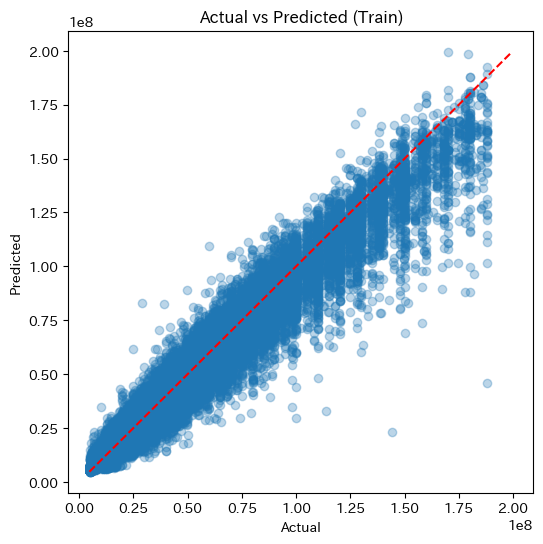

In [54]:
plt.figure(figsize=(6,6))
plt.scatter(train_df[target_col], y_pred_train, alpha=0.3)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Train)")

# 45度線（完璧な予測ライン）
min_val = min(train_df[target_col].min(), y_pred_train.min())
max_val = max(train_df[target_col].max(), y_pred_train.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.show()

## 特徴量重要度

In [55]:
base_fi = pd.DataFrame({
    "feature": fe_cols,
    "importance": base_model.feature_importances_
}).sort_values("importance", ascending=False)

low_fi = pd.DataFrame({
    "feature": fe_cols,
    "importance": low_model.feature_importances_
}).sort_values("importance", ascending=False)


In [56]:
base_fi.to_csv(f'{output_path}feature_importance_base.csv', index=False)
low_fi.to_csv(f'{output_path}feature_importance_low.csv', index=False)

#### 特徴量重要度=<2を削除

In [ ]:
# low_importance_feats = feature_importance.query("importance <= 2")["feature_name"].tolist()
# print(low_importance_feats)
# print(len(low_importance_feats))

# fe_cols = [c for c in fe_cols if c not in low_importance_feats]
# cat_cols = [c for c in cat_cols if c not in low_importance_feats]

['sin_lat', 'tiny_area_flag_30', 'unit_area_min', 'reform_wet_area 6', 'reform_pca_2', 'unit_facilities_tag_浴室1.6×2.0M以上', 'reform_interior 1', 'bukken_type', 'rosen_name1_te', 'land_area_all', 'unit_facilities_tag_家具・家電付', 'condition_pca_4', 'unit_facilities_tag_クローゼット', 'reform_pca_5', 'sin_lon', 'walk_distance_bin', 'Prefecture name_te', 'flg_new', 'cos_lon', 'building_facilities_tag_宅配ボックス', 'cos_lat', 'unit_facilities_tag_シャワー', 'unit_facilities_tag_オートバス', 'unit_facilities_tag_ガスコンロ設置済', 'unit_facilities_tag_ガスコンロ', 'unit_facilities_tag_シューズクローク', 'unit_facilities_tag_ガス暖房', 'unit_facilities_tag_コンロ四口以上', 'unit_facilities_tag_コンロ一口', 'unit_facilities_tag_エアコン', 'unit_facilities_tag_シャワー付洗面化粧台', 'building_type', 'unit_facilities_tag_インターネット対応', 'reform_or_cert_tag_新築時・増改築時の設計図書', 'reform_or_cert_tag_インスペクション（建物検査）報告書', 'unit_facilities_tag_シューズボックス', 'reform_or_cert_tag_低炭素住宅', 'reform_or_cert_tag_住宅性能保証制度証明書', 'reform_or_cert_tag_保証付住宅', 'reform_or_cert_tag_修繕・点検の記録', 'reform_or_

## 予測

In [58]:
# test データに対して最終予測
y_pred = predict_with_low_model(test_df, base_model, low_model, fe_cols)

# 必要に応じて安全クリップ（念のため）
# y_pred = np.clip(y_pred, 1e4, 3e8)

In [80]:
q = np.quantile(price, [0, 0.25, 0.5, 0.75, 0.99, 1])
print("Min      :", q[0])
print("25% (Q1) :", q[1])
print("Median   :", q[2])
print("75% (Q3) :", q[3])
print("99%      :", q[4])
print("Max      :", q[5])

Min      : 4900000.0
25% (Q1) : 13990000.0
Median   : 21800000.0
75% (Q3) : 32300000.0
99%      : 99500000.0
Max      : 188000000.0


In [60]:
q = np.quantile(y_pred, [0, 0.25, 0.5, 0.75, 0.99, 1])
print("Min      :", q[0])
print("25% (Q1) :", q[1])
print("Median   :", q[2])
print("75% (Q3) :", q[3])
print("99%      :", q[4])
print("Max      :", q[5])

Min      : 4838516.875621732
25% (Q1) : 14814031.466692712
Median   : 22420996.628938086
75% (Q3) : 32770253.72612626
99%      : 92702585.99914147
Max      : 179386645.08955008


In [59]:
assert np.isfinite(y_pred).all(), "NaN/Inf detected in predictions!"
assert (y_pred > 0).all(), "Negative price detected!"

## 提出

In [61]:
submit_df = pd.read_csv(submit_file_path, header=None)
submit_df.columns = ['id', 'pred']

In [62]:
submit_df['pred'] = y_pred

In [ ]:
submit_df.to_csv(
    f'{output_path}submit_20251204_v4.csv',
    index=False,
    header=False
)

#### 振り返り
- ベースモデル：場所・規模・築年・周辺相場が主役
- 小規模モデル：それに加えて「部屋のスペック・設備」で細かく調整

価格帯別にMAE、MPE、MAPEを比較する

以下はあまりEDAに時間をかけられない日に試す
- ブレンドの重み・閾値の微調整
    - 低価格判定閾値：LOW_PRICE_TH → 閾値を 800万 / 1200万 に振る
    - low_model への寄せ方：w_low → w_low を 0.5 / 0.6 / 0.8 で試す

## 地理EDA

In [53]:
df = train_df.copy()
df["y_pred_train"] = y_pred_train

# ゼロ割り防止（targetが0のものはNaNにして除外するなど）
eps = 1e-6
df["mape_train"] = (df["y_pred_train"] - df[target_col]).abs() / (df[target_col].abs() + eps)

# MAPEを階級に分ける（例）
bins = [0, 0.05, 0.10, 0.20, 0.50, np.inf]
labels = ["≦5%", "5–10%", "10–20%", "20–50%", ">50%"]
df["mape_bin"] = pd.cut(df["mape_train"], bins=bins, labels=labels, right=False)

In [55]:
df[['lat', 'lon', target_col, 'y_pred_train']]

,lat,lon,money_room,y_pred_train
0,35.047688,136.637467,13980000.0,1.378533e+07
1,35.074625,136.639936,24480000.0,2.282155e+07
2,35.072248,136.644708,24480000.0,2.058405e+07
3,35.003174,136.875602,16300000.0,2.073898e+07
4,35.002403,136.875754,18800000.0,1.789472e+07
...,...,...,...,...
363919,35.066899,136.688936,14300000.0,1.355023e+07
363920,35.064552,136.685451,18900000.0,1.943862e+07
363921,35.060995,136.686671,15900000.0,1.792992e+07
363922,34.933236,136.851469,47800000.0,4.686885e+07


In [57]:
df[['lat', 'lon', target_col, 'y_pred_train']].to_csv(
    f'{output_path}/地理EDA/train_df.csv',
    index=False
)